In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
import seaborn as sns
import tensorflow_hub as hub

train_dataframe = pd.read_csv('../input/covidx-cxr2/train.txt', sep=" ", header=None) #first argument = file_path, seperator = blankspace, No header
train_dataframe.columns = ['patient id', 'filename', 'labels', 'data source'] # column name of train_dataset
train_dataframe = train_dataframe.drop(['patient id','data source'], axis=1 ) #drop data source column
test_dataframe = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None) #first argument = file_path, seperator = blankspace, No header
test_dataframe.columns=['patient id', 'filename', 'labels', 'data source' ] # column name of test_dataset
test_dataframe = test_dataframe.drop(['patient id','data source'], axis=1 ) #drop data source column
print(train_dataframe.head(10)) # first 10 train_data_infos
print(test_dataframe.head(10))  # first 10 test_data_infos

train_dataframe, valid_dataframe = train_test_split(train_dataframe, train_size=0.9, random_state=0) #train_dataframe, valid_dataframe split from train_dataframe
print(train_dataframe.labels.value_counts())
print(valid_dataframe.labels.value_counts())
print(test_dataframe.labels.value_counts())
train_file_count = 10000 #total_count per each label
train_samples = []
for category in train_dataframe['labels'].unique():    
    category_slice = train_dataframe.query("labels == @category")    
    train_samples.append(category_slice.sample(train_file_count, replace=True,random_state=1))
train_dataframe = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (train_dataframe['labels'].value_counts())
print (len(train_dataframe))
val_file_count = 1000 #total_count per each label
val_samples = []
for category in valid_dataframe['labels'].unique():    
    category_slice = valid_dataframe.query("labels == @category")    
    val_samples.append(category_slice.sample(val_file_count, replace=True,random_state=1))
valid_dataframe = pd.concat(val_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (valid_dataframe['labels'].value_counts())
print (len(valid_dataframe))


target_size = (224,224) #target size
batch_size = 32 #batch size
train_path = '../input/covidx-cxr2/train/' #train path
test_path = '../input/covidx-cxr2/test/'   #test path

train_data_generator = ImageDataGenerator(  #Data Augmentation
    preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input, #preprocessing_input
    rotation_range = 25,  #random_rotaion
    horizontal_flip = True, #random_horizontal_flip
    zoom_range=0.1, #random_zoom(in,out)
)

test_data_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input #preprocessing_input
    
)

train_data = train_data_generator.flow_from_dataframe( #Generate Train_Data from Train_DataFrame
    train_dataframe,                  #train_dataframe
    directory = train_path,           #data_directory
    x_col = 'filename',               #x_col_name
    y_col = 'labels',                 #y_col_name
    target_size = target_size,        #(224,224)
    batch_size = batch_size,          #32
    color_mode = 'rgb',               #rgb mode
    class_mode = 'binary'             #binary class
) 


valid_data = test_data_generator.flow_from_dataframe( #Generate Valid_Data from Valid_DataFrame
    valid_dataframe,                   #valid_dataframe
    directory = train_path,            #data_directory
    x_col = 'filename',                #x_col_name
    y_col = 'labels',                  #y_col_name
    target_size = target_size,         #(224,224)
    batch_size = batch_size,           #32
    color_mode = 'rgb',                #rgb mode
    class_mode = 'binary'              #binary class
)

test_data = test_data_generator.flow_from_dataframe( #Generate Test_Data from Test_DataFrame
    test_dataframe,                   #test_dataframe
    directory = test_path,            #data_directory
    x_col = 'filename',               #x_col_name
    y_col = 'labels',                 #y_col_name
    target_size = target_size,        #(224,224)
    batch_size = batch_size,          #64
    color_mode = 'rgb',               #rgb mode
    class_mode = 'binary'             #binary class
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


                                    filename    labels
0  1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg  negative
1  7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg  negative
2  3392dc7d262e28423caca517f98c2e_jumbo.jpeg  negative
3  ec3a480c0926ded74429df416cfb05_jumbo.jpeg  negative
4   a72aeb349a63c79ed24e473c434efe_jumbo.jpg  negative
5   ba45a47c3ef5060ec39891046be7ca_jumbo.jpg  negative
6   6f36c4ad54047bc52b38fd8c9d1e22_jumbo.jpg  negative
7   621f53af15cf08e6e13cb6812eead9_jumbo.jpg  negative
8                               6646071b.jpg  negative
9                               5359825d.jpg  negative
                                    filename    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
5   MIDRC-RICORD-1C-SITE2-000265-99793-1.png  positive
6   MIDRC-

# loading pre-trained models (resnet,densenet and efficientnet) 

In [2]:

base_model_efficientnet = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
model_efficientnet = tf.keras.Sequential([
    base_model_efficientnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
efficientnet_model=model_efficientnet
efficientnet_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

efficientnet_model.load_weights('/kaggle/input/covid-efficient-weights/covid_efficientnet.h5') #loading saved weights
records = efficientnet_model.evaluate(test_data) #evaluation

266/266 [==============================] - 179s 658ms/step - loss: 0.8228 - accuracy: 0.5680 - precision: 0.5628 - recall: 0.6095 - true_positives: 2585.0000 - true_negatives: 2233.0000 - false_positives: 2008.0000 - false_negatives: 1656.0000


In [3]:

base_model_efficientnet = tf.keras.applications.DenseNet121(include_top=False, input_shape=(224, 224, 3))
model_efficientnet = tf.keras.Sequential([
    base_model_efficientnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
densenet_model=model_efficientnet
densenet_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
densenet_model.load_weights('/kaggle/input/covid-densenet-weights/covid_densenet.h5') #loading saved weights
records = densenet_model.evaluate(test_data) #evaluation

266/266 [==============================] - 101s 361ms/step - loss: 2.2265 - accuracy: 0.5430 - precision: 0.5404 - recall: 0.5756 - true_positives: 2441.0000 - true_negatives: 2165.0000 - false_positives: 2076.0000 - false_negatives: 1800.0000


In [4]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224,224,3)) #ResNet50V2 Model
model = tf.keras.Sequential([
    base_model,  #ResNet50V2
    tf.keras.layers.GlobalAveragePooling2D(), #Global Average Pooling(GAP), Reducing features
    tf.keras.layers.Dense(256, activation='relu'), #Dense layer with relu
    tf.keras.layers.BatchNormalization(), #BatchNormalization
    tf.keras.layers.Dropout(0.25), #DropOut
    tf.keras.layers.Dense(1, activation='sigmoid') #Dense layer with sigmoid
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
resnet_model = model
resnet_model.load_weights('/kaggle/input/covid-resnet-weights/covid_resnet (1).h5') #loading saved weights
records = resnet_model.evaluate(test_data) #evaluation

266/266 [==============================] - 98s 360ms/step - loss: 1.4480 - accuracy: 0.5245 - precision: 0.5239 - recall: 0.5381 - true_positives: 2282.0000 - true_negatives: 2167.0000 - false_positives: 2074.0000 - false_negatives: 1959.0000


# evaluation

In [41]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model


X_train,y_train=next(train_data)

# Define K-fold cross-validation
n_splits = 10  # folds = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store accuracy scores for each fold
resnet_accuracies = []
efficientnet_accuracies = []
densenet_accuracies = []
i=1
# Perform K-fold cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]


    #CNNs already have their weights adjusted. No train needed.
    resnet_predictions = resnet_model.predict(X_val_fold)
    efficientnet_predictions = efficientnet_model.predict(X_val_fold)
    densenet_predictions = densenet_model.predict(X_val_fold)
    # Stack predictions horizontally to create meta-dataset for validation
    resnet_accuracies.append(accuracy_score(y_val_fold, (resnet_predictions > 0.5).astype(int)))
    efficientnet_accuracies.append(accuracy_score(y_val_fold, (efficientnet_predictions > 0.5).astype(int)))
    densenet_accuracies.append(accuracy_score(y_val_fold, (densenet_predictions > 0.5).astype(int)))

1/1 [==============================] - 0s 26ms/step


In [42]:
dc = {'resnet_acc': resnet_accuracies, 'efficientnet_acc': efficientnet_accuracies, 'densenet_acc': densenet_accuracies}
df = pd.DataFrame(dc)
df.describe()

,resnet_acc,resnet_f1,efficientnet_acc,efficientnet_f1,densenet_acc,densenet_f1
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.808333,0.600000,0.741667,0.466667,0.900000,0.766667
std,0.166898,0.438854,0.138611,0.421637,0.161015,0.417222
min,0.666667,0.000000,0.666667,0.000000,0.666667,0.000000
25%,0.666667,0.166667,0.666667,0.000000,0.750000,0.750000
50%,0.708333,0.666667,0.666667,0.666667,1.000000,1.000000
75%,1.000000,1.000000,0.729167,0.666667,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


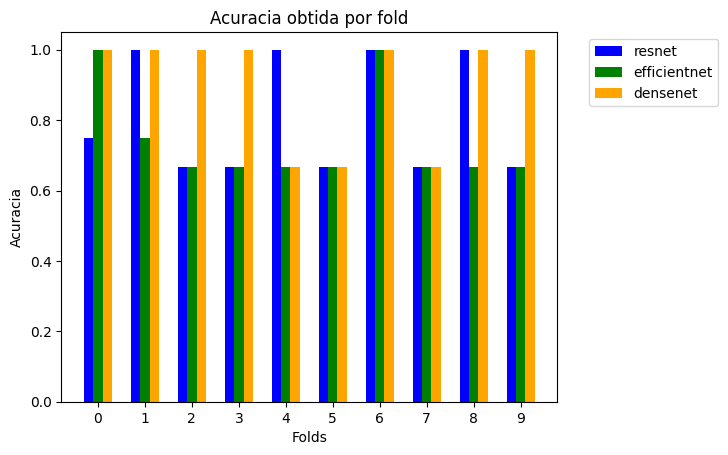

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

a = [10, 15, 20]
b = [25, 18, 30]
c = [12, 22, 15]

num_datasets = df.shape[0]

bar_width = 0.2

x_positions = np.arange(num_datasets)

plt.bar(x_positions - bar_width, df['resnet_acc'], width=bar_width, label='resnet', color='blue')
plt.bar(x_positions,df['efficientnet_acc'], width=bar_width, label='efficientnet', color='green')
plt.bar(x_positions + bar_width, df['densenet_acc'], width=bar_width, label='densenet', color='orange')

plt.xlabel('Folds')
plt.ylabel('Acuracia')
plt.title('Acuracia obtida por fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(x_positions, range(10))
plt.savefig(f"grafico.png")
#plt.legend()

plt.show()

In [58]:
display(df)

,resnet_acc,resnet_f1,efficientnet_acc,efficientnet_f1,densenet_acc,densenet_f1
0,0.750000,0.666667,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,0.750000,0.666667,1.000000,1.000000
2,0.666667,0.666667,0.666667,0.666667,1.000000,1.000000
3,0.666667,0.666667,0.666667,0.666667,1.000000,1.000000
4,1.000000,1.000000,0.666667,0.666667,0.666667,0.666667
5,0.666667,0.000000,0.666667,0.000000,0.666667,0.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.666667,0.000000,0.666667,0.000000,0.666667,0.000000
8,1.000000,1.000000,0.666667,0.000000,1.000000,1.000000
9,0.666667,0.000000,0.666667,0.000000,1.000000,1.000000
